# How to align with ultralytics yolov5

In [1]:
import os
import cv2

import torch

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from yolort.models.yolo import YOLO
from yolort.utils import (
    cv2_imshow,
    get_image_from_url,
    read_image_to_tensor,
)
from yolort.utils.image_utils import plot_one_box, color_list
from yolort.v5 import load_yolov5_model, letterbox, non_max_suppression, scale_coords

## Prepare image and model weights to test

In [3]:
# img_path = "https://raw.githubusercontent.com/zhiqwang/yolov5-rt-stack/main/test/assets/zidane.jpg"
img_path = "https://gitee.com/zhiqwang/yolov5-rt-stack/raw/master/test/assets/zidane.jpg"
img_raw = get_image_from_url(img_path)

# yolov5s6.pt is downloaded from 'https://github.com/ultralytics/yolov5/releases/download/v6.0/yolov5n6.pt'
path_ultralytics_weights = 'yolov5n6.pt'

In [4]:
# Preprocess
img = letterbox(img_raw, new_shape=(640, 640))[0]
img = read_image_to_tensor(img)
img = img.to(device)

## Load model as ultralytics and inference

In [5]:
score_thresh = 0.30
iou = 0.45

model = load_yolov5_model(path_ultralytics_weights, autoshape=False, verbose=True)
model = model.to(device)
model.conf = score_thresh  # confidence threshold (0-1)
model.iou = iou  # NMS IoU threshold (0-1)
model.classes = None  # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
model = model.eval()


                 from  n    params  module                                  arguments                     
  0                -1  1      1760  yolort.v5.models.common.Conv            [3, 16, 6, 2, 2]              
  1                -1  1      4672  yolort.v5.models.common.Conv            [16, 32, 3, 2]                
  2                -1  1      4800  yolort.v5.models.common.C3              [32, 32, 1]                   
  3                -1  1     18560  yolort.v5.models.common.Conv            [32, 64, 3, 2]                
  4                -1  2     29184  yolort.v5.models.common.C3              [64, 64, 2]                   
  5                -1  1     73984  yolort.v5.models.common.Conv            [64, 128, 3, 2]               
  6                -1  3    156928  yolort.v5.models.common.C3              [128, 128, 3]                 
  7                -1  1    221568  yolort.v5.models.common.Conv            [128, 192, 3, 2]              
  8                -1  1    167040  

In [6]:
with torch.no_grad():
    ultralytics_dets = model(img[None])[0]
    ultralytics_dets = non_max_suppression(ultralytics_dets, score_thresh, iou, agnostic=True)[0]

In [7]:
ultralytics_dets

tensor([[7.20445e+01, 1.13266e+02, 5.26275e+02, 3.68607e+02, 8.27893e-01, 0.00000e+00],
        [3.72172e+02, 2.75398e+01, 5.79932e+02, 3.68102e+02, 7.79096e-01, 0.00000e+00],
        [2.08252e+02, 2.29428e+02, 2.52494e+02, 3.69399e+02, 3.11370e-01, 2.70000e+01]])

## Updating model weights from ultralytics to yolort and inference

In [8]:
model = YOLO.load_from_yolov5(
    path_ultralytics_weights,
    score_thresh=score_thresh,
    nms_thresh=iou,
    version="r6.0",
)

model.eval()

with torch.no_grad():
    yolort_dets = model(img[None])


                 from  n    params  module                                  arguments                     
  0                -1  1      1760  yolort.v5.models.common.Conv            [3, 16, 6, 2, 2]              
  1                -1  1      4672  yolort.v5.models.common.Conv            [16, 32, 3, 2]                
  2                -1  1      4800  yolort.v5.models.common.C3              [32, 32, 1]                   
  3                -1  1     18560  yolort.v5.models.common.Conv            [32, 64, 3, 2]                
  4                -1  2     29184  yolort.v5.models.common.C3              [64, 64, 2]                   
  5                -1  1     73984  yolort.v5.models.common.Conv            [64, 128, 3, 2]               
  6                -1  3    156928  yolort.v5.models.common.C3              [128, 128, 3]                 
  7                -1  1    221568  yolort.v5.models.common.Conv            [128, 192, 3, 2]              
  8                -1  1    167040  

In [9]:
print(f"Detection boxes with yolort:\n{yolort_dets[0]['boxes']}")

Detection boxes with yolort:
tensor([[ 72.04449, 113.26617, 526.27472, 368.60730],
        [372.17160,  27.53978, 579.93250, 368.10205],
        [208.25206, 229.42764, 252.49397, 369.39944]])


In [10]:
print(f"Detection scores with yolort:\n{yolort_dets[0]['scores']}")

Detection scores with yolort:
tensor([0.82789, 0.77910, 0.31137])


In [11]:
print(f"Detection labels with yolort:\n{yolort_dets[0]['labels']}")

Detection labels with yolort:
tensor([ 0,  0, 27])


## Varify the detection results between yolort and ultralytics

In [12]:
# Testing boxes
torch.testing.assert_allclose(
    yolort_dets[0]['boxes'], ultralytics_dets[:, :4], rtol=1e-05, atol=1e-07)
# Testing scores
torch.testing.assert_allclose(
    yolort_dets[0]['scores'], ultralytics_dets[:, 4], rtol=1e-05, atol=1e-07)
# Testing labels
torch.testing.assert_allclose(
    yolort_dets[0]['labels'], ultralytics_dets[:, 5].to(dtype=torch.int64), rtol=1e-05, atol=1e-07)

print("Exported model has been tested, and the result looks good!")

Exported model has been tested, and the result looks good!


## Detection output visualisation

In [13]:
# Get label names
import requests

# label_path = "https://raw.githubusercontent.com/zhiqwang/yolov5-rt-stack/master/notebooks/assets/coco.names"
label_path = "https://gitee.com/zhiqwang/yolov5-rt-stack/raw/master/notebooks/assets/coco.names"
response = requests.get(label_path)
names = response.text

LABELS = []

for label in names.strip().split('\n'):
    LABELS.append(label)

COLORS = color_list()

The labels can also be obtained by

```python
from yolort.utils.image_utils import load_names
labels = load_names('./assets/coco.names')
```

Hah, that's the trick to rescale the box correctly

In [14]:
boxes = scale_coords(img.shape[1:], yolort_dets[0]['boxes'], img_raw.shape[:-1])
labels = yolort_dets[0]['labels']

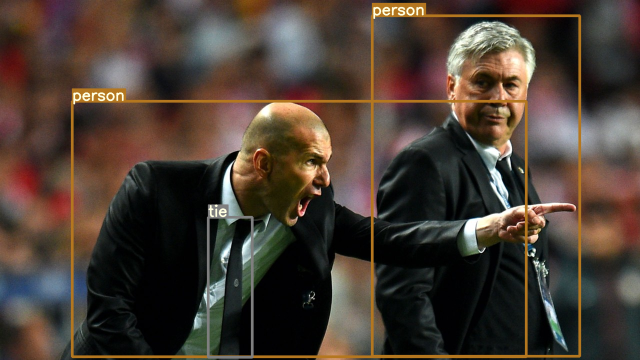

In [15]:
for box, label in zip(boxes.tolist(), labels.tolist()):
    img_raw = plot_one_box(box, img_raw, color=COLORS[label % len(COLORS)], label=LABELS[label])

cv2_imshow(img_raw, imshow_scale=0.5)